# Initialization and Optimization

```{admonition} Attribution
This notebook is based on [Tutorial 3: Initialization and Optimization](https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/03-initialization-and-optimization.html) of the [Pytorch Lightining official tutorials](https://pytorch-lightning.readthedocs.io/en/latest/index.html) with PyTorch code translated to TensorFlow and with significant additions to the material. 
```

In this notebook, we will review techniques for optimization and initialization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. This is why we will take a closer look at the following concepts: initialization and optimization.

In the first half of the notebook, we will review different initialization techniques, and go step by step from the simplest initialization to methods that are nowadays used in very deep networks. In the second half, we focus on optimization comparing the optimizers SGD, SGD with Momentum, and Adam.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)
tf.config.list_physical_devices()

2.7.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import pathlib
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm
import os
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Path to datasets
DATASET_PATH = pathlib.Path(os.getcwd()).parents[2] / "data"
DATASET_PATH.mkdir(exist_ok=True, parents=True)

## Preparation

Throughout this notebook, we will use a deep fully connected network, similar to our previous tutorial. We will also again apply the network to FashionMNIST, so you can relate to the results in the previous notebook. We start by loading the FashionMNIST dataset:


In [3]:
# Transformations applied on each image. 
def transform_image(image):
    return tf.reshape(tf.image.per_image_standardization(image), (-1,))


FMNIST, FMNIST_info = tfds.load(
    'fashion_mnist', 
    data_dir=DATASET_PATH, 
    with_info=True, 
    shuffle_files=False
)

train_ds, test_ds = FMNIST['train'], FMNIST['test']
train_ds = train_ds.map(lambda x: (transform_image(x['image']), x['label']))
test_ds = test_ds.map(lambda x: (transform_image(x['image']), x['label']))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-02-23 17:44:55.565406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-23 17:44:55.565837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In comparison to the previous tutorial, we rescaled each image from `[0, 255]` to `[0, 1]`. The normalization is now designed to give us an expected mean of `0` and a standard deviation of `1` across pixels for each image. This will be particularly relevant for the discussion about initialization we will look at below, and hence we change it here. It should be noted that in most classification tasks, both normalization techniques (between -1 and 1 or mean 0 and standard deviation 1) have shown to work well. 

Let's look at the distribution of pixel values in a batch of images (after standardization). Note that the maximum and minimum are not 1 and -1 anymore, but shifted towards the positive values.

/Users/particle1331/miniforge3/envs/ml/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


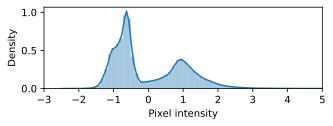

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1.5))
batch = next(iter(train_ds.batch(4096)))[0].numpy()
sns.distplot(batch.reshape(-1), bins=120);
ax.set_xlim([-3, 5])
ax.set_xlabel("Pixel intensity");

Next, we create a linear neural network. We use the same setup as in the previous tutorial.


In [5]:
def base_net(act_fn, num_classes=10, hidden_sizes=(512, 256, 256, 128)):
    """Return an initialized MLP network with dense hidden layers with activation
    `act_fn` and width in `hidden_sizes` ordered such that index zero is nearest 
    the input layer, and a final linear layer `num_classes` output neurons."""

    model = tf.keras.Sequential()

    # Add hidden layers with activation
    for j in range(len(hidden_sizes)):
        model.add(tf.keras.layers.Dense(units=hidden_sizes[j]))
        model.add(act_fn())

    # Add logit linear layer
    model.add(tf.keras.layers.Dense(units=num_classes))
    return model

For the activation functions, we make use of Keras' `tf.keras.activations` library instead of implementing ourselves. We also define an `Identity` activation function. Although this activation function would significantly limit the network’s modeling capabilities, we will use it in the first steps of our discussion about initialization.

In [6]:
class Identity(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return x
        
        
class Tanh(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return tf.keras.activations.tanh(x)
        

class ReLU(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return tf.keras.activations.relu(x)


act_fn_by_name = {
    "tanh": Tanh,
    "relu": ReLU,
    "identity": Identity
}

Finally, we define a few plotting functions that we will use for our discussions. These functions help us to visualize (1) the weight distribution inside a network, (2) the gradients that the parameters at different layers receive, and (3) the activations, i.e. the output of the linear layers. The detailed code is not important, but feel free to take a closer look if interested.

In [7]:
def plot_distributions(dist: dict, color="C0", xlabel=None, stat="count", use_kde=True, xlim=None):
    cols = len(dist)
    fig, ax = plt.subplots(1, cols, figsize=(cols*3, 3.0), dpi=80)
    fig_index = 0
    for key in sorted(dist.keys()):
        # Plot distribution
        ax_key = ax[fig_index % cols]
        sns.histplot(
            dist[key], ax=ax_key, color=color, bins=50, stat=stat, 
            kde=use_kde and ((dist[key].max() - dist[key].min()) > 1e-8) # plot KDE only if nonzero variance
        ) 

        # Formatting
        ax_key.set_xlabel(xlabel)
        ax_key.set_xlim(xlim)
        ax_key.set_title(str(key))
        fig_index += 1
    
    fig.subplots_adjust(wspace=0.4)
    return fig


def plot_weight_distribution(model, color="C0"):
    # Exclude the bias to reduce the number of plots
    weights = {}
    for layer_index, layer in enumerate(model.layers):
        for w in layer.trainable_variables:
            if "bias" in w.name:
                continue
            key_name = f"({layer_index}) {w.name.split('/')[0]}"
            weights[(layer_index, key_name)] = w.numpy().reshape(-1)

    # Plotting
    fig = plot_distributions(weights, color=color)
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return weights


def plot_gradient_distribution(model, color="C0", print_variance=False, xlim=None):
    small_loader = train_ds.batch(batch_size=1024)
    images, labels = next(iter(small_loader))

    # Pass the batch through the network, and calculate the gradients for the weights
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    with tf.GradientTape(persistent=True) as tape:
        preds = model(images)
        loss = loss_fn(labels, preds)
    
    # Exclude the bias to reduce the number of plots
    grads_dict = {}
    for layer_index, layer in enumerate(model.layers):
        grads = tape.gradient(loss, layer.variables)
        for j in range(len(layer.variables)):
            w = layer.variables[j]
            if (not w.trainable) or ("bias" in w.name):
                continue
            grads_dict[(layer_index, f"({layer_index}) {w.name.split('/')[0]}")] = grads[j].numpy().reshape(-1)

    ## Plotting
    fig = plot_distributions(grads_dict, color=color, xlabel="Grad magnitude", xlim=xlim)
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads_dict.keys()):
            print(f"{key[1]:<12}  σ²_grad = {np.var(grads_dict[key]):.5e}")

    return grads_dict


def plot_activations_distribution(model, color="C0", print_variance=False, xlim=None):
    small_loader = train_ds.batch(batch_size=1024)
    images, labels = next(iter(small_loader))
    activations = {}
    x = images
    for layer_index, layer in enumerate(model.layers):
        x = layer(x)
        if not isinstance(layer, tf.keras.layers.Dense):
            activations[(layer_index, f"({layer_index}) {layer.name.split('/')[0]}")] = x.numpy().reshape(-1)

    ## Plotting
    fig = plot_distributions(activations, color=color, stat="density", xlim=xlim)
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key[1]:<15}  σ²_act = {np.var(activations[key]):.5e}")
        
    return activations

**Remark.** Observe that neurons in the hidden layers are identically distributed during initialization, by symmetry. This allows us to combine all values in the `(B, m)` matrix into a histogram of `B * m` samples whose distribution should reflect the distribution of each individual output neuron. This doesn't hold for neurons in the input and output layers which have different distributions. Consequently, histogram plots for the input and output layers should be interpreted as an aggregated distribution which will generally differ from the individual distributions of each neuron. 

## Initialization

Training deep neural networks is essentially an optimization problem (in very high dimensions) with the network weights as parameters and the loss as objective. Thus, we have to choose initial values for the weights.
When initializing a neural network, there are a few properties we would like to have. First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate.

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.



In [8]:
model = base_net(lambda: Identity()) # = linear transformation
model.build(input_shape=(None, 784))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 identity (Identity)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 identity_1 (Identity)       (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 identity_2 (Identity)       (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

To easily visualize various initialization schemes, we define the following function. Note that bias weights are initialized to zero.

In [9]:
from typing import Callable

def visualize_initialization(act_fn: Callable, init_fn: Callable, 
    plot_grad=True, plot_act=True, xlim_grad=None, xlim_act=None):
    model = base_net(act_fn)
    model.build(input_shape=(None, 784))

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            kernel_shape = layer.get_weights()[0].shape
            bias_shape   = layer.get_weights()[1].shape
            fan_in  = kernel_shape[0]
            fan_out = kernel_shape[1]
            kernel_weights = init_fn(fan_in, fan_out)(kernel_shape)
            bias_weights = tf.keras.initializers.Zeros()(bias_shape) # b = 0
            layer.set_weights([kernel_weights, bias_weights])
    
    if plot_grad:
        gradients = plot_gradient_distribution(
            model, color="C1",
            print_variance=True,
            xlim=xlim_grad,
        )
    else:
        gradients = {}
    
    if plot_act:
        activations = plot_activations_distribution(
            model, color="C2", 
            print_variance=True,
            xlim=xlim_act,
        )
    else:
        activations = {}

    return {
        'gradients': gradients,
        'activations': activations
    }

### Constant initialization

The first initialization we can consider is to initialize all weights with the same constant value. Intuitively, setting all weights to zero is not a good idea as the propagated gradient will be zero since we have a constant loss surface. However, what happens if we set all weights to some nonzero constant? Note that using a large constant will make the network have exploding activations since neurons accumulate the input vector into a weighted sum. What happens if we set all weights to a value slightly larger or smaller than 0? To find out, we can implement a function for setting all parameters below and visualize the gradients.

2022-02-23 17:45:01.485083: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


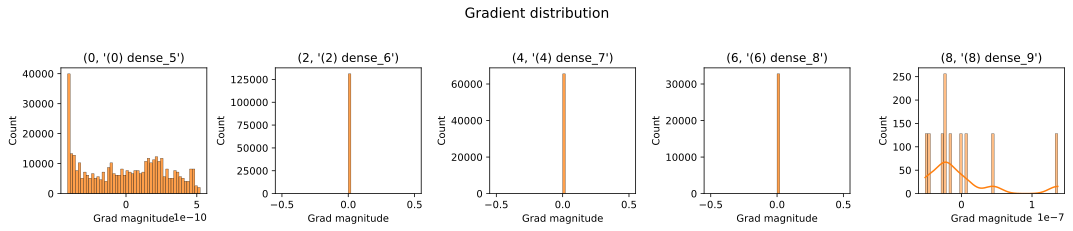

(0) dense_5   σ²_grad = 7.78136e-20
(2) dense_6   σ²_grad = 0.00000e+00
(4) dense_7   σ²_grad = 0.00000e+00
(6) dense_8   σ²_grad = 0.00000e+00
(8) dense_9   σ²_grad = 2.75408e-15


2022-02-23 17:45:02.553512: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


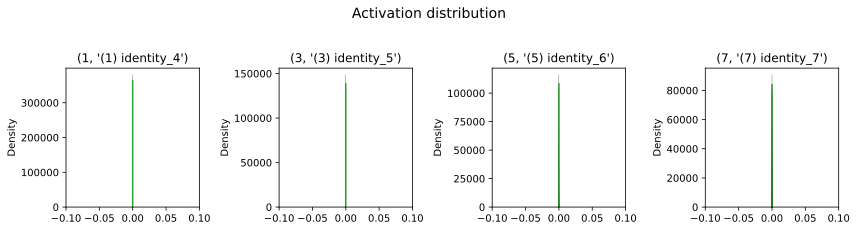

(1) identity_4   σ²_act = 2.72334e-12
(3) identity_5   σ²_act = 1.78477e-11
(5) identity_6   σ²_act = 2.92416e-11
(7) identity_7   σ²_act = 4.79095e-11


In [10]:
result = visualize_initialization(
    act_fn=lambda: Identity(), 
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.Constant(value=0.005),
    xlim_act=[-0.1, 0.1]
)

As we can see, only the first and the last layer have diverse gradient distributions each intermediate hidden layers have the same gradient for all weights (note that this value is unequal to 0, but often very close to it &mdash; see print below). Due to symmetry, all intermediate neurons belonging to the same layer will be equivalent, and therefore have the same gradient updates (essentially reducing the effective number of parameters to 1 for these layers). 

The only sources of assymetry are the inputs and outputs, which explains the nonzero variance in the gradients of the first and last layers (see code cell below). For example, different pixels have different distributions. Thus, we cannot a constant initialization as this greatly reduces the network's capacity to learn.

In [11]:
# Printing gradient stats for the first, third, and last layers
print("Gradients:") 
layer_grads = lambda j: result['gradients'][sorted(result['gradients'].keys())[j]]
print(f"μ = ({layer_grads(0).mean():.5e}, {layer_grads(2).mean():.5e}, {layer_grads(-1).mean():.5e})")
print(f"σ = ( {layer_grads(0).std():.5e}, {layer_grads(2).std():.5e},  {layer_grads(-1).std():.5e})")

# Printing activation stats for the first, third, and last layers
print("\nActivations:") 
layer_acts = lambda j: result['activations'][sorted(result['activations'].keys())[j]]
print(f"μ = ({layer_acts(0).mean():.5e}, {layer_acts(2).mean():.5e}, {layer_acts(-1).mean():.5e})")
print(f"σ = ( {layer_acts(0).std():.5e},  {layer_acts(2).std():.5e},  {layer_acts(-1).std():.5e})")

Gradients:
μ = (-2.77556e-17, 4.74382e-18, -1.06581e-15)
σ = ( 2.78951e-10, 0.00000e+00,  5.24793e-08)

Activations:
μ = (-1.61243e-09, -5.28336e-09, -6.76319e-09)
σ = ( 1.65025e-06,  5.40755e-06,  6.92167e-06)


### Constant variance


From the experiment above, we have seen that a constant value is not working. So to break symmetry, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let’s implement it below, and visualize the activation distribution across layers.

2022-02-23 17:45:05.605717: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


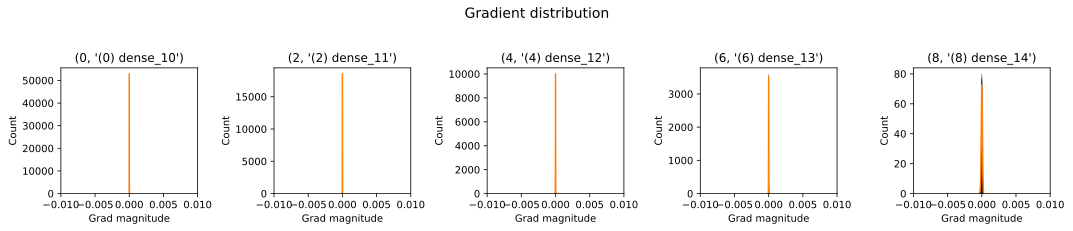

(0) dense_10  σ²_grad = 2.36352e-11
(2) dense_11  σ²_grad = 7.44267e-11
(4) dense_12  σ²_grad = 1.36769e-10
(6) dense_13  σ²_grad = 2.80448e-10
(8) dense_14  σ²_grad = 7.20163e-09


2022-02-23 17:45:08.126878: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


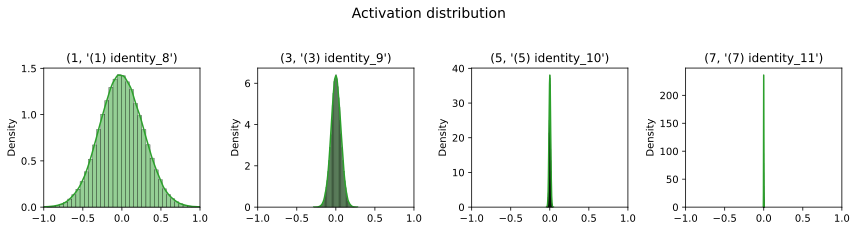

(1) identity_8   σ²_act = 7.76782e-02
(3) identity_9   σ²_act = 4.06882e-03
(5) identity_10  σ²_act = 1.09182e-04
(7) identity_11  σ²_act = 2.89081e-06


In [12]:
result = visualize_initialization(
    act_fn=lambda: Identity(), 
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.RandomNormal(stddev=0.01),
    xlim_grad=[-0.01, 0.01],
    xlim_act=[-1, 1],
)

The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer. Alternatively, we could use a higher standard deviation:


2022-02-23 17:45:11.664390: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


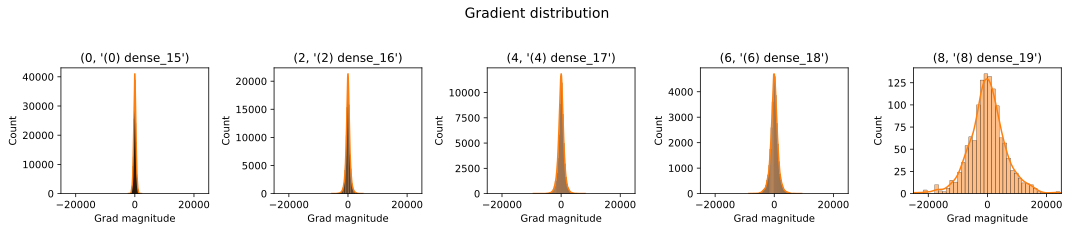

(0) dense_15  σ²_grad = 1.63114e+05
(2) dense_16  σ²_grad = 5.08641e+05
(4) dense_17  σ²_grad = 1.01448e+06
(6) dense_18  σ²_grad = 1.70529e+06
(8) dense_19  σ²_grad = 3.96022e+07


2022-02-23 17:45:13.964582: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


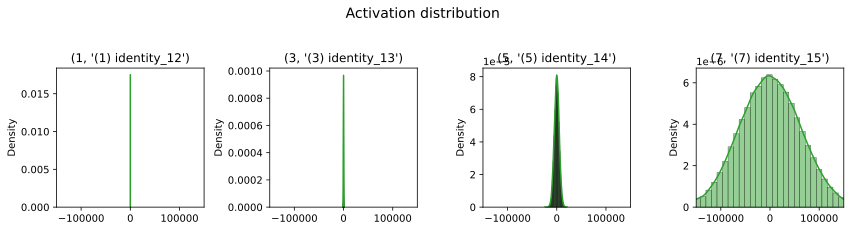

(1) identity_12  σ²_act = 5.02026e+02
(3) identity_13  σ²_act = 1.62309e+05
(5) identity_14  σ²_act = 2.48822e+07
(7) identity_15  σ²_act = 3.96698e+09


In [13]:
result = visualize_initialization(
    act_fn=lambda: Identity(), 
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.RandomNormal(stddev=0.8),
    xlim_grad=[-25000, 25000],
    xlim_act=[-150000, 150000],
)

With a higher standard deviation, the activations are likely to explode. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model. If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended.

### How to find appropriate initialization values

Suppose we want to design an initialization for the linear layer which computes $\mathbf y= \mathbf x \boldsymbol W + \boldsymbol b$ with $\mathbf y\in\mathbb{R}^{d_{\mathbf y}}$, $\mathbf x\in\mathbb{R}^{d_{\mathbf x}}$. From our experiments above, we saw that we need to optimally sample weights to ensure healthy distribution of activation values. For this, we state two requirements: 

1. The mean of the activations should be zero.
2. The variance of the activations should stay the same across every layer. 

Note that the activation neurons in a single layer are independent and identically distributed, so we can write the variance as $\sigma_{\mathbf y}^{2} = \text{Var}(y_i).$ It follows that $\boldsymbol b = \mathbf 0$ since the bias is constant across different inputs. Next, it makes sense to set the mean of the weights to zero for the sake of symmetry. This also means that we only have to calculate the variance which can be done as follows:

$$\begin{split}
    \sigma_{\mathbf y}^{2} = \text{Var}(y_i) & = \text{Var}\left(\sum_{j} w_{ij}x_{j}\right)\\
    & = \sum_{j} \text{Var}(w_{ij}x_{j})\\
    & = \sum_{j} \text{Var}(w_{ij})\ \text{Var}(x_{j})\\
    & = d_{\mathbf x} \  \text{Var}(w_{ij})\ \text{Var}(x_{j}) = d_{\mathbf x}\, \sigma_{\boldsymbol W}^2 \, \sigma_{\mathbf x}^{2}.
\end{split}
$$

The second line follows from the variance of a sum of independent random variables, while the third line follows from the variance of a product of two independent random variables with zero mean. Note that $\mathbf x$ also has zero mean since its either an output of a hidden layer (inductive hypothesis) or a feature vector (preprocessing). In the last line, we assumed that $x_j$ are independent and identically distributed for all $j$ (not true for input and output layers). 
It follows that $\sigma_{\boldsymbol W}^2 = \frac{1}{d_{\mathbf x}}$ so that $\sigma^2_{\mathbf y} = \sigma^2_{\mathbf x}.$ In words, we should initialize the weight distribution with a variance equal to the inverse of the layer's input dimension. Let's implement it below and check whether this holds:

2022-02-23 17:45:17.114903: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


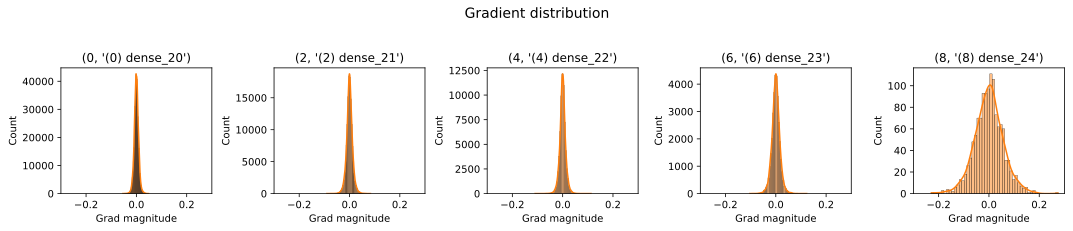

(0) dense_20  σ²_grad = 7.44815e-05
(2) dense_21  σ²_grad = 1.45677e-04
(4) dense_22  σ²_grad = 1.43628e-04
(6) dense_23  σ²_grad = 2.64054e-04
(8) dense_24  σ²_grad = 3.25722e-03


2022-02-23 17:45:19.344900: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


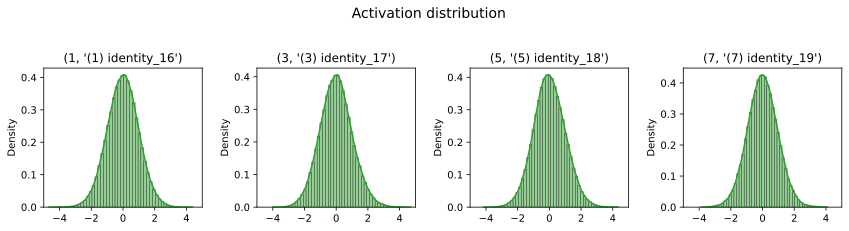

(1) identity_16  σ²_act = 9.68700e-01
(3) identity_17  σ²_act = 1.01643e+00
(5) identity_18  σ²_act = 9.70898e-01
(7) identity_19  σ²_act = 9.00436e-01


In [14]:
result = visualize_initialization(
    act_fn=lambda: Identity(), 
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.RandomNormal(stddev=1/np.sqrt(fan_in)),
    xlim_grad=[-0.3, 0.3],
    xlim_act=[-5, 5],
)

As we expected, the variance stays indeed constant across layers. Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of $0$ and variance of $\frac{1}{d_{\mathbf x}}.$ You often see that a uniform distribution is used for initialization. A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

In the above plot, we see that gradients slightly vanish nearer the inputs. Indeed, besides the variance of the activations, another variance we would like to stabilize is the one of the gradients.  This ensures a stable optimization for deep networks. From our work on backpropagation on MLPs, we know that
$\frac{\partial \mathcal L}{\partial \mathbf x} = \frac{\partial \mathcal L}{\partial \mathbf y} \boldsymbol W^\top.$
Hence
$\sigma^2_{\boldsymbol W^\top} = \sigma^2_{\boldsymbol W} = \frac{1}{d_\mathbf y}.$
As a compromise between both constraints, [Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi) proposed to use the harmonic mean of both values. This leads us to the well-known **Xavier initialization**:

$$\boldsymbol W\sim \mathcal{N}\left(0,\frac{2}{d_{\mathbf x}+d_{\mathbf y}}\right).$$

If we use a uniform distribution, we would initialize the weights with:

$$\boldsymbol W\sim U\left[-\frac{\sqrt{6}}{\sqrt{{d_{\mathbf x}+d_{\mathbf y}}}}, \frac{\sqrt{6}}{\sqrt{{d_{\mathbf x}+d_{\mathbf y}}}}\right].$$

Let's shortly implement it and validate its effectiveness:

2022-02-23 17:45:22.367258: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


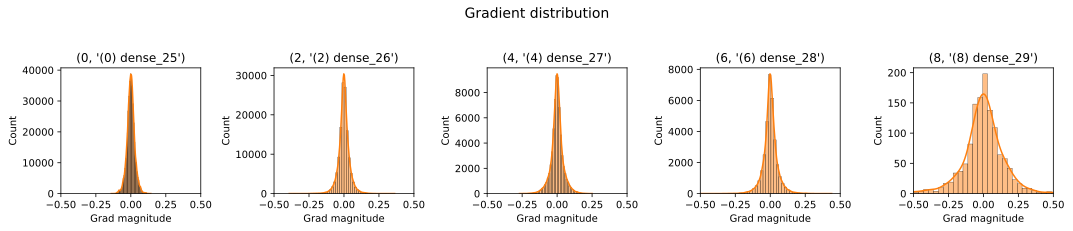

(0) dense_25  σ²_grad = 7.69383e-04
(2) dense_26  σ²_grad = 1.54660e-03
(4) dense_27  σ²_grad = 1.88833e-03
(6) dense_28  σ²_grad = 2.68132e-03
(8) dense_29  σ²_grad = 2.53531e-02


2022-02-23 17:45:24.707076: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


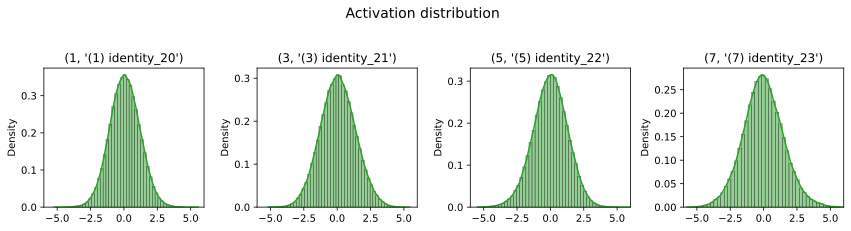

(1) identity_20  σ²_act = 1.25340e+00
(3) identity_21  σ²_act = 1.69678e+00
(5) identity_22  σ²_act = 1.64976e+00
(7) identity_23  σ²_act = 2.21893e+00


In [15]:
result = visualize_initialization(
    act_fn=lambda: Identity(), 
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.RandomNormal(stddev=np.sqrt(1/(0.5*(fan_in + fan_out)))),
    xlim_grad=[-0.5, 0.5],
    xlim_act=[-6, 6],
)

We see that the Xavier initialization balances the variance of gradients and activations (the variance of the gradients increased by one order of magnitude). Note that the significantly higher variance for the output layer is due to the large difference of input and output dimension (128 vs 10).

#### Using Xavier initialization on $\tanh$ networks

In the discussions above, we assumed the activation function to be linear. So what happens if we add a non-linearity? In a tanh-based network, a common assumption is that for small values during the initial steps in training, the $\tanh$ works as a linear function such that we don’t have to adjust our calculation. We can check if that is the case for us as well.

Recall $\sigma_{\mathbf x_1} = \left(\sum_{j=1}^{784} {\sigma_{ x_0, j}^{2}}\right) \sigma_{\boldsymbol W_1}^2$ in the dense part of the input layer which pushes the $\tanh$ activations to $\pm 1$ in the first activation. This can limit the expressivity of input features. Then, the next layer will receive an input of mostly $\pm 1$ so that the saturation persists in the deeper layers.

2022-02-23 17:45:27.819447: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


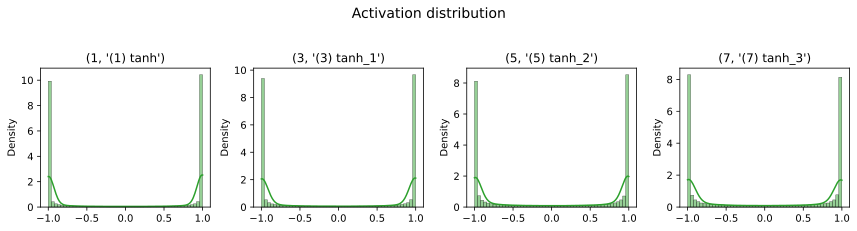

(1) tanh         σ²_act = 9.04020e-01
(3) tanh_1       σ²_act = 8.76801e-01
(5) tanh_2       σ²_act = 8.26106e-01
(7) tanh_3       σ²_act = 8.21413e-01


In [16]:
visualize_initialization(
    act_fn=lambda: Tanh(), 
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.RandomNormal(stddev=0.3), 
    plot_grad=False
);

For small fixed $\sigma,$ we get similar behavior with the identity network since for small input, $\tanh x \approx x.$ Thus, we get vanishing activations. (See explanation above in terms of vanishing $\sigma_{\mathbf x_t}.$)

2022-02-23 17:45:30.890924: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


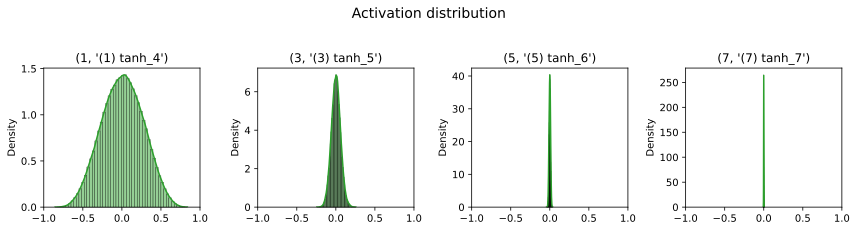

(1) tanh_4       σ²_act = 6.91921e-02
(3) tanh_5       σ²_act = 3.50690e-03
(5) tanh_6       σ²_act = 9.26244e-05
(7) tanh_7       σ²_act = 2.35419e-06


In [17]:
visualize_initialization(
    act_fn=lambda: Tanh(), 
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.RandomNormal(stddev=0.01), 
    plot_grad=False,
    xlim_act=[-1, 1]
);

Let's try to initialize with Xavier normalization. This should work fairly well since $\tanh$ is approximately linear between -1 and 1. Indeed, observe that we get healthier activation distribution compared to initializing the weights with constant variance above.

2022-02-23 17:45:34.066070: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


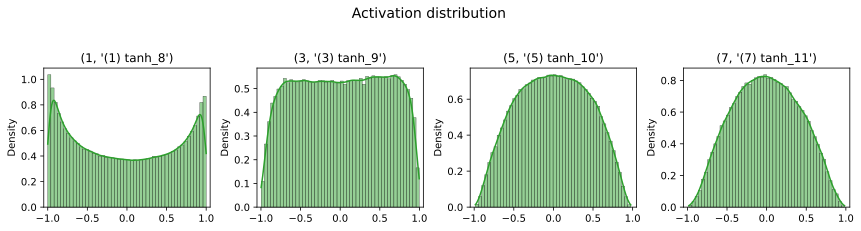

(1) tanh_8       σ²_act = 4.23304e-01
(3) tanh_9       σ²_act = 2.94319e-01
(5) tanh_10      σ²_act = 1.92783e-01
(7) tanh_11      σ²_act = 1.67977e-01


In [18]:
result = visualize_initialization(
    act_fn=lambda: Tanh(), 
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.RandomNormal(stddev=np.sqrt(1 / (0.5*(fan_in + fan_out)))),
    plot_grad=False,
    xlim_act=[-1.05, 1.05]
)

#### Kaiming initialization for ReLU networks

But what about ReLU networks? Here, we cannot take the previous assumption of the non-linearity becoming linear for small values.  Suppose $\mathbf y = \mathbf x\boldsymbol W$ such that $\mathbf x = \text{ReLU}(\tilde {\mathbf y}),$ we want to initialize the weights such that (1) $\mathbb E[y_j] = \mathbb E[\tilde{y_j}] = 0$ and (2) $\sigma^2_\mathbf y = \sigma^2_{\tilde {\mathbf y}}.$ As long as the expectation of $\boldsymbol W$ is zero and $\boldsymbol b= \mathbf 0$, the expectation of the output is zero. This takes care of (1). For requirement (2), the part where the calculation of the ReLU initialization differs from the identity is when determining $\text{Var}(w_{ij}x_{j})$: 

$$
\text{Var}(w_{ij} x_{j} ) = 
\underbrace{\mathbb{E} [ w_{ij}^2 ]}_{=\text{Var}(w_{ij})} \;
\mathbb{E}[x_{j}^2]-\underbrace{\mathbb{E}[w_{ij}]^2}_{=0}\;\mathbb{E}[ x_{j} ]^2=\text{Var}(w_{ij})\;\mathbb{E}[x_{j}^2].
$$

If we assume now that $\mathbf x$ is the output of a ReLU activation, we can calculate the expectation as follows. In the first equality $p$ is the probability distribution of $\tilde y_j$ which we can assume to be symmetric around zero:

$$
\begin{split}
\mathbb{E}[x_j^2] 
&= \int_{-\infty}^{\infty} \max(0, t)^2 p(t) dt \\
&= \int_0^{\infty} t^2 p(t) dt = \frac{1}{2}\int_{-\infty}^{\infty} t^2 p(t) dt = \frac{1}{2}\text{Var}(\tilde{y}_j)
\end{split}$$


Thus, we have $\sigma^2_{\mathbf y} = \frac{1}{2}\sum_{j} \sigma^2_{\boldsymbol W} \sigma^2_{\tilde {\mathbf y}}= \frac{1}{2} d_\mathbf{x} \sigma^2_{\boldsymbol W} \sigma^2_{\tilde {\mathbf y}}$ so that our desired weight variance becomes $\sigma^2_{\boldsymbol W} = \frac{2}{d_{\mathbf x}}$. This gives us the Kaiming initialization [[He, K. et al. (2015)]](https://arxiv.org/pdf/1502.01852.pdf). Note that the Kaiming initialization does not use the harmonic mean between input and output size. In their paper (Section 2.2, Backward Propagation, last paragraph), they argue that using $d_{\mathbf x}$ or $d_{\mathbf y}$ both lead to stable gradients throughout the network, and only depend on the overall input and output size of the network. Hence, we can use here only the input $d_{\mathbf x}.$

2022-02-23 17:45:37.561459: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


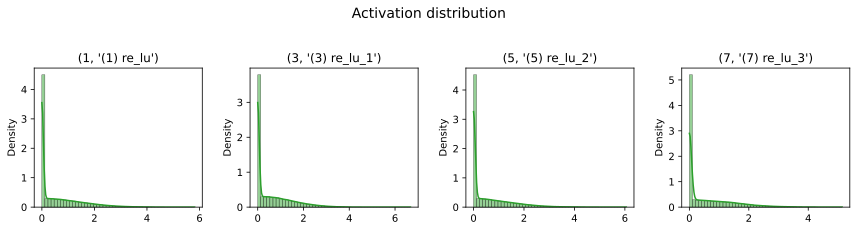

(1) re_lu        σ²_act = 6.38307e-01
(3) re_lu_1      σ²_act = 6.27589e-01
(5) re_lu_2      σ²_act = 6.33228e-01
(7) re_lu_3      σ²_act = 5.96459e-01


In [19]:
visualize_initialization(
    act_fn=lambda: ReLU(),
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.RandomNormal(stddev=np.sqrt(2 / fan_in)),
    plot_grad=False
);

In contrast, having no factor of 2 results in vanishing activation values: 

2022-02-23 17:45:40.755427: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


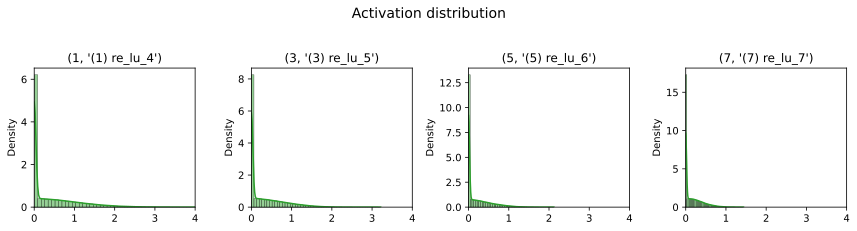

(1) re_lu_4      σ²_act = 3.46577e-01
(3) re_lu_5      σ²_act = 1.83771e-01
(5) re_lu_6      σ²_act = 8.51797e-02
(7) re_lu_7      σ²_act = 4.63810e-02


In [20]:
visualize_initialization(
    act_fn=lambda: ReLU(),
    init_fn=lambda fan_in, fan_out: tf.keras.initializers.RandomNormal(stddev=np.sqrt(1 / fan_in)),
    plot_grad=False,
    xlim_act=[0, 4],
);

The activation variance stays stable across layers. We can conclude that the Kaiming initialization indeed works well for ReLU-based networks. Note that for other activations we have to slightly adjust the factor in the variance. For instance, for LeakyReLU half of the values are not set to zero anymore, and calculating a similar integral as above results in a factor of $\frac{2}{1 + \alpha^2}$ instead of $2$ for the ReLU.

```{note}
To initialize with different scale factors, Keras implements the `VarianceScaling` initializer which samples weights from a normal distribution with mean zero and standard deviation `stddev = sqrt(scale / n)` where `n` depends on the `mode` with `'fan_in'`, `'fan_out'`, and `'fan_avg'` as possible values. In particular, Kaiming corresponds to `scale=2` and `mode='fan_in'`. Xavier corresponds to `scale=1` and `mode='fan_avg'`. Note that same with other normal initializers, Keras truncates the sample space to prevent initializing too large weights. 
```

### Understanding activation and gradient flow

Suppose we index layers and weights as in {numref}`neuralnet-layers` with $\mathbf x_0$ as input data. It follows that $\sigma_{\mathbf x_{t+1}}^{2} = d_{\mathbf x_{t}}\, \sigma_{\mathbf x_{t}}^{2}\, \sigma_{\boldsymbol W_t}^2$ for $t \geq 1$ and $\sigma_{\mathbf x_1} = \left(\sum_{j=1}^{784} {\sigma_{ x_0, j}^{2}}\right) \sigma_{\boldsymbol W_0}^2.$ Thus, applying the formula recursively, we get

$$\sigma_{\mathbf x_t}^{2} = \left( \prod_{k=1}^{t-1} d_{\mathbf x_k} \right) \left(\sum_{j=1}^{784} {\sigma_{ x_0, j}^{2}} \right)\left(\prod_{k=0}^{t-1} \sigma_{\boldsymbol W_k}^2\right).$$ 

This formula explains why activations and gradients blow up as we go deeper into the layers for a network initialized with sufficiently large constant variance for the weights, and vanishes with depth for sufficiently small constant variance. For example, $\sigma_{\boldsymbol W_k}^2 = \frac{1}{d_{\mathbf x_{k}}}$ in Xavier initialization, so that everything balances out, leaving $\sigma_{\mathbf x_t}^{2} = \frac{1}{d_{\mathbf x_0}} \sum_{j=1}^{784} {\sigma_{ x_0, j}^{2}}$ which has the correct scale. The sum term is due to different pixels having non-identical distributions (we still assume independence between pixels which is generally false, e.g. adjacent pixels can have some dependence). Note that we have the same equation for gradients but in reverse (starting from the logits layer). 

```{figure} ../../img/neuralnet-layers.png
---
width: 30em
name: neuralnet-layers
---
Schematic diagram of a feedforward neural network. 
```

Recall the identity network initialized with constant variance $\sigma = 0.8$ had exploding activations, while for $\sigma=0.01$ it had vanishing activations. Let's test whether our computations are consistent:

In [21]:
x = next(iter(train_ds.batch(1024)))[0].numpy()
v = np.square(x.std(axis=0)).sum()
256 * 256 * 512 * v * ((0.8) ** 2) ** 4

2022-02-23 17:45:44.210936: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2893753113.5361047

In [22]:
x = next(iter(train_ds.batch(1024)))[0].numpy()
v = np.square(x.std(axis=0)).sum()
256 * 256 * 512 * v * ((0.01) ** 2) ** 4

2022-02-23 17:45:44.336771: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1.7248112640000004e-06

Consider the input layer $\mathbf x_1 = \mathbf x_0 \boldsymbol W_0,$ then we obtain $\frac{\partial \mathcal L}{\partial \boldsymbol W_0} = {\mathbf x_0^\top} \frac{\partial \mathcal L}{\partial \mathbf x_1}$ by backpropagating from $\mathbf x_1$ to $\boldsymbol W_0.$ Similarly, we can backpropagate from $\mathbf x_2$ to $\mathbf x_1$ in the next layer $\mathbf x_2 = \mathbf x_1 \boldsymbol W_1$ to get
$\frac{\partial \mathcal L}{\partial \mathbf x_1} = \frac{\partial \mathcal L}{\partial \mathbf x_2} \boldsymbol W_1^\top.$
Continuing this process, we get the weight gradient of the input layer in terms of the weight gradients of the logits layer $\mathbf x_5$ (which we have easy access to):

$$\frac{\partial \mathcal L}{\partial \boldsymbol W_0} = {\mathbf x_0^\top} \frac{\partial \mathcal L}{\partial \mathbf x_5} (\boldsymbol W_1\boldsymbol W_2 \boldsymbol W_3 \boldsymbol W_4)^\top$$

This can be extended to 
$\frac{\partial \mathcal L}{\partial \boldsymbol W_t} = {\mathbf x_t^\top} \frac{\partial \mathcal L}{\partial \mathbf x_d} \prod_{j=d-1}^{t+1} \boldsymbol W_{j}^\top$ where $0 \leq t \leq d-1$ and we shift the starting point, so we can get the gradient of any intermediate layer of the network. Notice the stack of weight matrices &mdash; this product can explode or vanish depending on the magnitude of the weights. Moreover, the formula lends itself to the same variance analysis used for activations with output size as factors instead of input size which motivates fan averaging in Xavier initialization:

$$\sigma_{\frac{\partial \mathcal L}{\partial \boldsymbol W_t} }^{2} = {\sigma_{{\mathbf x_0^\top} \frac{\partial \mathcal L}{\partial \mathbf x_5}}^{2}} \prod_{k=d-1}^{t+1} \sigma_{\boldsymbol W_k}^2 d_{\mathbf x_{k+1}}  .$$ 


As an aside, while you might expect that exploding activations imply exploding gradients, e.g. for the network initialized with fixed $\sigma_{\mathbf W_{k}} = 0.8$, this is not the case: shallower layers have lower activations, hence may have lower weight gradients because of the factor ${\mathbf x_t^\top}.$

In [23]:
model = base_net(act_fn=lambda: Identity(), hidden_sizes=[512, 256, 256, 128])
model.build(input_shape=(None, 784))

# Initialization
init = tf.keras.initializers.RandomNormal(stddev=0.1)
zero = tf.keras.initializers.Zeros()
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.set_weights([
            init(layer.get_weights()[0].shape),
            zero(layer.get_weights()[1].shape)
        ])

# Forward pass
small_loader = train_ds.batch(batch_size=256)
images, labels = next(iter(small_loader))
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acts_dict = {}
x = images
acts_dict[0] = x.numpy()
for layer_index, layer in enumerate(model.layers):
    x = layer(x)
    if not isinstance(layer, tf.keras.layers.Dense):
        acts_dict[layer_index] = x.numpy()

# Backward pass
with tf.GradientTape(persistent=True) as tape:
    preds = model(images)
    loss = loss_fn(labels, preds)

grads_dict = {}
for layer_index, layer in enumerate(model.layers):
    grads = tape.gradient(loss, layer.variables)
    for j in range(len(layer.variables)):
        w = layer.variables[j]
        if (not w.trainable) or ("bias" in w.name):
            continue
        grads_dict[layer_index] = grads[j].numpy()

2022-02-23 17:45:44.534916: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Let's check if the above formula works:

In [24]:
import functools

def weights_gradient_formula(t):
    logits_grad = tape.gradient(loss, preds).numpy()
    X = acts_dict[sorted(acts_dict.keys())[t]]
    weights = [h.get_weights()[0] for h in model.layers if isinstance(h, tf.keras.layers.Dense)]

    if t > len(weights) - 1:
        raise IndexError    
    else:
        return functools.reduce(lambda x, y: x @ y.T, weights[len(weights)-1:t:-1], X.T @ logits_grad)


errors = []
for t in range(len(grads_dict)):
    W0_grad = weights_gradient_formula(t)
    errors.append(np.abs(W0_grad - grads_dict[sorted(grads_dict.keys())[t]]).mean())

errors = np.array(errors)
errors.min(), errors.max()

(3.3638134e-08, 1.4171046e-07)

Note that the batch dimension gets summed over inside ${\mathbf x_0^\top} \frac{\partial \mathcal L}{\partial \mathbf x_d}.$ The small differences between the gradients obtained using autodifferentiation, and the gradients obtained using backpropagation is most likely due to numerical instability as `logits_grad` is sparse. Indeed, decreasing $\sigma$ results in a less sparse weight gradient for the logits layer and a smaller error, and vice-versa.

In [25]:
logits_grad = tape.gradient(loss, preds).numpy()
(logits_grad > 1e-10).sum() / len(logits_grad.reshape(-1))

0.302734375

```{note}
For networks with nonlinear activations, we can account for the gradient flow across the activations by replacing $\frac{\partial \mathcal L}{\partial \mathbf x_d}$ with $\frac{\partial \mathcal L}{\partial \mathbf x_d} \otimes \varphi^\prime(\mathbf z_{d-1})$ and $\boldsymbol W_{j}^\top$ with $\boldsymbol W_{j}^\top \otimes \varphi^\prime (\mathbf z_{j-1})$ where $\mathbf x_k = \phi (\mathbf z_{k-1})$ is the nonlinear activation applied entrywise to $\mathbf z_{k-1} = \mathbf x_{k-1} \boldsymbol W_{k-1}.$ Thus, 

$$\frac{\partial \mathcal L}{\partial \boldsymbol W_t} = {\mathbf x_t^\top} \left(\frac{\partial \mathcal L}{\partial \mathbf x_d} \otimes \varphi^\prime(\mathbf z_{d-1}) \right) \prod_{j= d-1}^{t+1} \left(\boldsymbol W_{j}^\top  \otimes \varphi^\prime (\mathbf z_{j-1}) \right)^\top$$

for any $0 \leq t \leq d-1.$ This network should have similar asymptotic behavior to the version with identity activations.
```

## Optimization

Besides initialization, selecting a suitable optimization algorithm can be an important choice for deep neural networks. First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network's parameters given the gradients. Hence, we effectively implement a function ${\boldsymbol w}^{t} = f({\boldsymbol w}^{t-1}, {\boldsymbol g}^{t}, ...)$ with $\boldsymbol w$ being the parameters, and ${\boldsymbol g}^{t} = \nabla_{{\boldsymbol w}^{(t-1)}} \mathcal{L}^{(t)}$ the gradients at time step $t$. A common, additional parameter to this function is the learning rate, here denoted by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps. 

### Optimization algorithms

As most optimizers only differ in the implementation of $f$, we can define a template for an optimizer below. We take as input the parameters of a model and a learning rate. The `step()` function tells the optimizer to update all weights based on their gradients.

In [26]:
class OptimizerTemplate:
    def __init__(self, model, learning_rate):
        self.model = model
        self.learning_rate = learning_rate

    def step(self, grads):
        for w, g in zip(self.model.trainable_variables, grads):
            self.update_param(w, g)
    
    def update_param(self, weight, grad):
        raise NotImplementedError

#### SGD

The first optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD). SGD updates the parameters using the following equation:

$$
\begin{split}
    {\boldsymbol w}^{(t)} & = {\boldsymbol w}^{(t-1)} - \eta\, {\boldsymbol g}^{(t)}
\end{split}
$$

As simple as the equation is also our implementation of SGD:

In [27]:
class SGD(OptimizerTemplate):
    def __init__(self, model, learning_rate):
        super().__init__(model, learning_rate)

    def update_param(self, weight, grad):
        dw = -self.learning_rate * grad
        weight.assign_add(dw)

#### SGD with Momentum

SGD can be improved using the concept of **momentum** which replaces the gradient in the update by an exponential average of all past gradients including the current one:

$$
\begin{split}
    \boldsymbol{m}^{(t)} & = \beta_1 \boldsymbol{m}^{(t-1)} + (1 - \beta_1)\, {\boldsymbol g}^{(t)}\\
    {\boldsymbol w}^{(t)} & = {\boldsymbol w}^{(t-1)} - \eta\, \boldsymbol{m}^{(t)}\\
\end{split}
$$

Let's also implement it below:

In [28]:
class SGDMomentum(OptimizerTemplate):
    def __init__(self, model, learning_rate, momentum=0.0):
        super().__init__(model, learning_rate)
        self.beta = momentum
        self.m = {w.name: tf.zeros_like(w) for w in model.trainable_variables}

    def update_param(self, weight, grad):
        self.m[weight.name] = self.beta * self.m[weight.name] + (1 - self.beta) * grad
        dw = -self.learning_rate * self.m[weight.name]
        weight.assign_add(dw)

#### Adam

Finally, we arrive at Adam. Adam combines the idea of momentum with an adaptive learning rate, which is based on an exponential average of the squared gradients, i.e. the gradients norm. Furthermore, we add a bias correction for the momentum and adaptive learning rate for the first iterations:

$$
\begin{split}
    {\boldsymbol m}^{(t)} & = \beta_1 {\boldsymbol m}^{(t-1)} + (1 - \beta_1)\, {\boldsymbol g}^{(t)}\\
    {\boldsymbol v}^{(t)} & = \beta_2 {\boldsymbol v}^{(t-1)} + (1 - \beta_2)\, \left({\boldsymbol g}^{(t)}\right)^2\\
    \hat{{\boldsymbol m}}^{(t)} & = \frac{{\boldsymbol m}^{(t)}}{1-\beta^{t}_1},\; \hat{{\boldsymbol v}}^{(t)} = \frac{{\boldsymbol v}^{(t)}}{1-\beta^{t}_2}\\
    {\boldsymbol w}^{(t)} & = {\boldsymbol w}^{(t-1)} - \frac{\eta}{\sqrt{{\boldsymbol v}^{(t)}} + \epsilon}\circ \hat{\boldsymbol m}^{(t)}\\
\end{split}
$$

Here $\epsilon$ is a small constant used to improve numerical stability for very small gradient norms. Remember that the adaptive learning rate does not replace the learning rate hyperparameter $\eta,$ but rather acts as an extra factor and ensures that the gradients of various parameters have a similar norm. 

In [29]:
class Adam(OptimizerTemplate):
    def __init__(self, model, learning_rate, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(model, learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # (t = 0)
        self.m = {w.name: tf.zeros_like(w) for w in model.trainable_variables}
        self.v = {w.name: tf.zeros_like(w) for w in model.trainable_variables}
        self.param_step = {w.name: 0 for w in model.trainable_variables} # time steps for each variable

    def update_param(self, weight, grad):
        # fetch prev. momentum and second momentum
        self.m[weight.name] = self.beta1 * self.m[weight.name] + (1 - self.beta1) * grad
        self.v[weight.name] = self.beta2 * self.v[weight.name] + (1 - self.beta2) * (grad ** 2)
        
        # bias correction
        self.param_step[weight.name] += 1
        t = self.param_step[weight.name]
        m_hat = self.m[weight.name] / (1 - self.beta1**t)
        v_hat = self.v[weight.name] / (1 - self.beta2**t)

        # update weights
        dw = -self.learning_rate * (m_hat / (tf.sqrt(v_hat) + self.eps))
        weight.assign_add(dw)

### Comparing optimizers on model training

After we have implemented three optimizers (SGD, SGD with momentum, and Adam), we can start to analyze and compare them. 
First, we test them on how well they can optimize a neural network on the FashionMNIST dataset. We use again our linear network, this time with a ReLU activation and the Kaiming initialization, which we have found before to work well for ReLU-based networks. Note that the model is over-parameterized for this task, and we can achieve similar performance with a much smaller network (for example `100, 100, 100`). However, our main interest is in how well the optimizer can train *deep* neural networks, hence the over-parameterization.

In [30]:
model = tf.keras.Sequential()

# add hidden layers with relu activation
hidden_sizes=[512, 256, 256, 128]
for j in range(len(hidden_sizes)):
    model.add(tf.keras.layers.Dense(
        units=hidden_sizes[j],
        kernel_initializer=tf.keras.initializers.HeNormal(),
        activation='relu'
    ))

# add logit linear layer
model.add(tf.keras.layers.Dense(
    units=10,
    kernel_initializer=tf.keras.initializers.HeNormal(),
    activation='relu'
))

# build model
model.build(input_shape=(None, 784))

Let's define a training function.

In [31]:
from sklearn import metrics

def train_model(model, optim, max_epochs=40, batch_size=256):
    # loss function
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Recall shuffle, batch, repeat pattern to create epochs
    train_loader = train_ds.shuffle(buffer_size=10000)
    train_loader = train_loader.batch(batch_size=batch_size, drop_remainder=True)
    train_loader = train_loader.repeat(max_epochs)
    train_loader = train_loader.prefetch(buffer_size=batch_size)    # Prepare next elements 
                                                                    # while current is preprocessed. 
                                                                    # Trades off latency with memory.

    valid_loader = test_ds.shuffle(buffer_size=4096)
    valid_loader = valid_loader.batch(2048)
    valid_loader = valid_loader.repeat()
    valid_iterator = iter(valid_loader)

    # training
    train_loss = []
    valid_loss = []
    valid_acc = []
    step = 0
    for x_train, y_train in tqdm(train_loader):
        with tf.GradientTape() as tape:
            loss = loss_fn(y_train, model(x_train))

        grads = tape.gradient(loss, model.trainable_variables)
        optim.step(grads)
        train_loss.append(loss)

        # compute valid. loss and valid. accuracy
        if step % batch_size == 0:
            x_valid, y_valid = next(valid_iterator)
            valid_loss.append(loss_fn(y_valid, model(x_valid)))
            valid_acc.append(
                metrics.accuracy_score(
                    y_valid, 
                    model.predict(x_valid).argmax(axis=1)
                )
            )
        step += 1

    return {
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "valid_acc": valid_acc
    }

For a fair comparison, we train the exact same model with the same initialization with the three optimizers below. Feel free to change the hyperparameters if you want.

In [32]:
model_sgd = tf.keras.models.clone_model(model)
results_sgd = train_model(model_sgd, SGD(model_sgd, learning_rate=1e-2), max_epochs=10, batch_size=256)

100%|██████████| 2340/2340 [00:28<00:00, 82.17it/s] 


In [33]:
model_sgdm = tf.keras.models.clone_model(model)
results_sgdm = train_model(model_sgdm, SGDMomentum(model_sgdm, learning_rate=1e-1, momentum=0.9), max_epochs=10, batch_size=256)

100%|██████████| 2340/2340 [00:34<00:00, 67.77it/s] 


In [34]:
model_adam = tf.keras.models.clone_model(model)
results_adam = train_model(model_adam, Adam(model_adam, learning_rate=1e-3), max_epochs=10, batch_size=256)

100%|██████████| 2340/2340 [00:50<00:00, 46.07it/s]


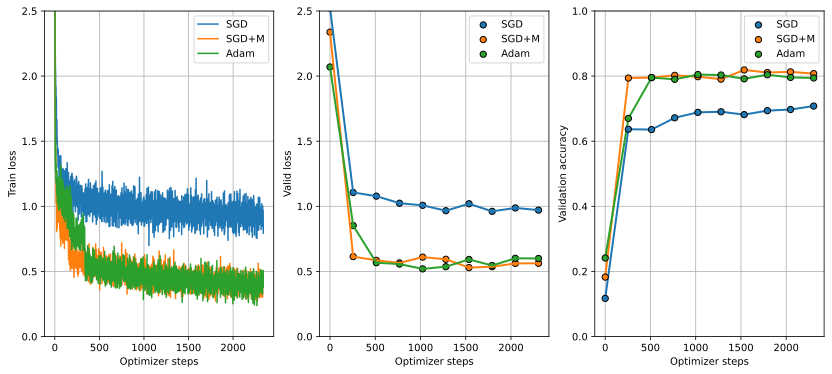

In [35]:
x = [256*i for i in range(len(results_sgd['valid_loss']))]
fig, ax = plt.subplots(1, 3, figsize=(14, 6), dpi=600)
ax[0].plot(results_sgd['train_loss'], color="C0", label='SGD', zorder=2)
ax[0].plot(results_sgdm['train_loss'], color="C1", label='SGD+M', zorder=2)
ax[0].plot(results_adam['train_loss'], color="C2", label='Adam', zorder=2)
ax[0].legend()
ax[0].set_ylabel("Train loss")
ax[0].set_xlabel("Optimizer steps");
ax[0].set_ylim(0, 2.5)
ax[0].grid()
ax[0].legend()

ax[1].scatter(x, results_sgd['valid_loss'], color="C0", s=40, edgecolor='black', label="SGD", zorder=2)
ax[1].scatter(x, results_sgdm['valid_loss'], color="C1", s=40, edgecolor='black', label="SGD+M", zorder=2)
ax[1].scatter(x, results_adam['valid_loss'], color="C2", s=40, edgecolor='black', label="Adam", zorder=2)
ax[1].plot(x, results_sgd['valid_loss'], color="C0", linewidth=2, zorder=2)
ax[1].plot(x, results_sgdm['valid_loss'], color="C1", linewidth=2, zorder=2)
ax[1].plot(x, results_adam['valid_loss'], color="C2", linewidth=2, zorder=2)
ax[1].set_ylim(0, 2.5)
ax[1].set_ylabel("Valid loss")
ax[1].set_xlabel("Optimizer steps");
ax[1].grid()
ax[1].legend();

ax[2].scatter(x, results_sgd['valid_acc'], color="C0", s=40, edgecolor='black', label="SGD", zorder=3)
ax[2].scatter(x, results_sgdm['valid_acc'], color="C1", s=40, edgecolor='black', label="SGD+M", zorder=3)
ax[2].scatter(x, results_adam['valid_acc'], color="C2", s=40, edgecolor='black', label="Adam", zorder=3)
ax[2].plot(x, results_sgd['valid_acc'], color="C0", linewidth=2, zorder=2)
ax[2].plot(x, results_sgdm['valid_acc'], color="C1", linewidth=2, zorder=2)
ax[2].plot(x, results_adam['valid_acc'], color="C2", linewidth=2, zorder=2)
ax[2].legend()
ax[2].grid()
ax[2].set_ylabel("Validation accuracy")
ax[2].set_ylim(0, 1)
ax[2].set_xlabel("Optimizer steps");

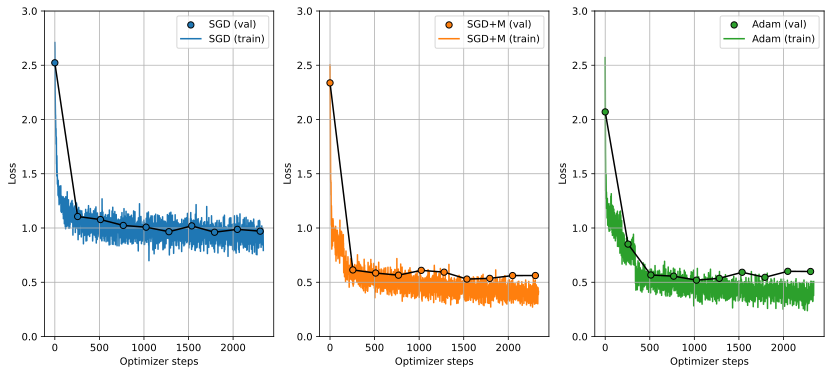

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6), dpi=600)
ax[0].scatter(x, results_sgd['valid_loss'], color="C0", s=40, edgecolor='black', label="SGD (val)", zorder=3)
ax[0].plot(x, results_sgd['valid_loss'], color="black", zorder=2)
ax[0].plot(results_sgd['train_loss'], color="C0", label='SGD (train)', zorder=1)
ax[0].legend()
ax[0].set_ylim(0, 3)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Optimizer steps");
ax[0].grid()
ax[0].legend()

ax[1].scatter(x, results_sgdm['valid_loss'], color="C1", s=40, edgecolor='black', label="SGD+M (val)", zorder=3)
ax[1].plot(x, results_sgdm['valid_loss'], color="black", zorder=2)
ax[1].plot(results_sgdm['train_loss'], color="C1", label='SGD+M (train)', zorder=1)
ax[1].legend()
ax[1].set_ylim(0, 3)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Optimizer steps");
ax[1].grid()
ax[1].legend()

ax[2].scatter(x, results_adam['valid_loss'], color="C2", s=40, edgecolor='black', label="Adam (val)", zorder=3)
ax[2].plot(x, results_adam['valid_loss'], color="black", zorder=2)
ax[2].plot(results_adam['train_loss'], color="C2", label='Adam (train)', zorder=1)
ax[2].legend()
ax[2].set_ylim(0, 3)
ax[2].set_ylabel("Loss")
ax[2].set_xlabel("Optimizer steps");
ax[2].grid()
ax[2].legend();

Overall accuracy on the whole test set:

In [37]:
from sklearn.metrics import accuracy_score
x_test, y_test = next(iter(test_ds.batch(10000)))

print("Test accuracies:")
print(f"  SGD     {accuracy_score(y_test, model_sgd.predict(x_test).argmax(axis=1))*100:.2f}%")
print(f"  SGD+M   {accuracy_score(y_test, model_sgdm.predict(x_test).argmax(axis=1))*100:.2f}%")
print(f"  Adam    {accuracy_score(y_test, model_adam.predict(x_test).argmax(axis=1))*100:.2f}%")

Test accuracies:
  SGD     68.96%
  SGD+M   81.13%
  Adam    79.37%


### Testing optimizers on exotic surfaces

The result above is that all optimizers perform similarly well with the given model. The differences are too small to find any significant conclusion. However, keep in mind that this can also be attributed to the initialization we chose. When changing the initialization to worse (e.g. constant initialization), Adam usually shows to be more robust because of its adaptive learning rate. To show the specific benefits of the optimizers, we will continue to look at some possible loss surfaces in which momentum and adaptive learning rate are crucial.

#### Pathological curvatures

A pathological curvature is a type of surface that is similar to ravines and is particularly tricky for plain SGD optimization. In words, pathological curvatures typically have a steep gradient in one direction with an optimum at the center, while in a second direction we have a slower gradient towards a (global) optimum. Let’s first create an example surface of this and visualize it:

In [38]:
def plot_surface(f, title, ax, x_range=(-5, 5), y_range=(-15, 5), cmap=cm.viridis):

    # Plot surface on xy plane; choose 3d or 2d plot
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y).numpy()

    # Plot    
    ax.plot_surface(X, Y, Z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
    ax.set_zlabel("loss", rotation=90)
    
    # Formatting plot
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()

    return ax


def plot_contour(f, title, ax, x_range=(-5, 5), y_range=(-15, 5), cmap=cm.viridis):

    # Plot surface on xy plane; choose 3d or 2d plot
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y).numpy()
    
    # Plot
    ax.contourf(X, Y, Z)
    
    # Formatting
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()

    return ax



Consider the function below which has a long, narrow, parabolic shaped flat valley. In terms of optimization, you can image that $w_1$ and $w_2$ are weight parameters, and the curvature represents the loss surface over the space of $w_1$ and $w_2$. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.


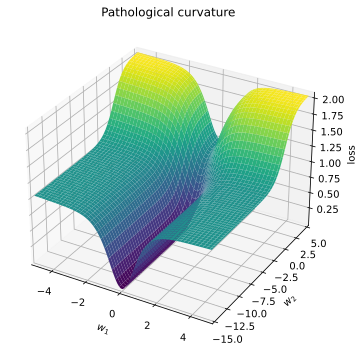

In [39]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, 
    # feel free to experiment here!
    x1_loss = tf.keras.activations.tanh(w1)**2 + 0.01 * tf.abs(w1)
    x2_loss = tf.keras.activations.sigmoid(w2)
    return x1_loss + x2_loss

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
plot_surface(pathological_curve_loss, title="Pathological curvature", ax=ax)
plt.show();

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of $w_2$. However, if we encounter a point along the ridges, the gradient is much greater in $w_1$ than $w_2$, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface:

In [40]:
class OptimModel(tf.keras.Model):
    def __init__(self, init):
        super().__init__()
        self.w1 = tf.Variable(init[0], name='w1', trainable=True)
        self.w2 = tf.Variable(init[1], name='w2', trainable=True)


def get_optimizer_path(optim_fn, init, loss_surface, num_steps=100):
    """Plots trajectory of optimizer from initial point (`init`) along a surface
    (`loss_surface`) in minimizing it via gradient updates. Here `optim_func` is
    a function that takes an OptimModel and returns an optimizer. The output of
    this function is a list of 2-tuples which correspond to (x, y) coords of the
    points in its trajectory."""

    model = OptimModel(init)
    optim = optim_fn(model)
    path = [model.get_weights()]
    losses = []

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            weights = model.trainable_variables
            loss = loss_surface(*weights)

        grads = tape.gradient(loss, weights)
        optim.step(grads)
        path.append(model.get_weights())
        losses.append(loss.numpy())

    return np.array(path), losses

Compute trajectories of gradient descent for the three optimizers starting from `(-5, 5)`:

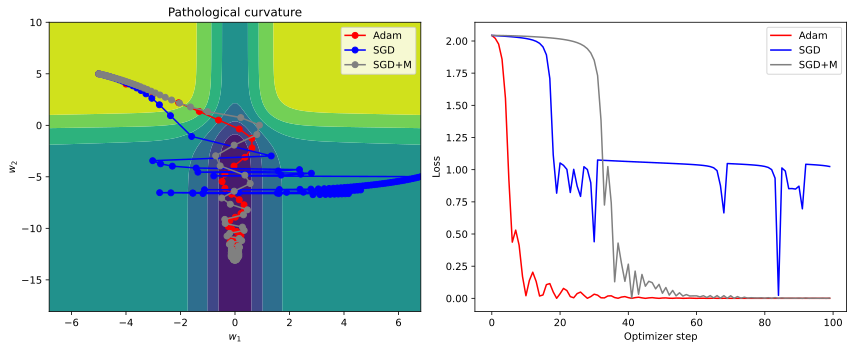

In [41]:
adam = lambda model: Adam(model, learning_rate=1)
sgd  = lambda model: SGD(model, learning_rate=10)
sgdm = lambda model: SGDMomentum(model, learning_rate=10, momentum=0.9)

init = [-5., 5.]
path_adam, losses_adam = get_optimizer_path(adam, init, pathological_curve_loss)
path_sgd,  losses_sgd  = get_optimizer_path(sgd,  init, pathological_curve_loss)
path_sgdm, losses_sgdm = get_optimizer_path(sgdm, init, pathological_curve_loss)

# Get ranges of coordinates of the optimization trajectories + padding
# x = w1 and y = w2, i.e. see ordering on output of get_weights function
all_points = np.concatenate([path_adam, path_sgd, path_sgdm], axis=0)
x_range = (-np.abs(all_points[:, 0]).max(), np.abs(all_points[:, 0]).max())
y_range = (all_points[:, 1].min() - 5, all_points[:, 1].max() + 5)

# Plot surface on box defined by coordinate ranges
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_contour(pathological_curve_loss, "Pathological curvature", ax=ax[0], x_range=x_range, y_range=y_range)

# Plot trajectory of optimizers
ax[0].plot(path_adam[:, 0], path_adam[:, 1], color="red",  marker="o", zorder=1, label="Adam")
ax[0].plot(path_sgd [:, 0], path_sgd [:, 1], color="blue", marker="o", zorder=1, label="SGD")
ax[0].plot(path_sgdm[:, 0], path_sgdm[:, 1], color="gray", marker="o", zorder=1, label="SGD+M")
ax[0].legend()

# Plot loss per optimizer step
ax[1].plot(losses_adam, label='Adam',  color="red")
ax[1].plot(losses_sgd,  label='SGD',   color="blue")
ax[1].plot(losses_sgdm, label='SGD+M', color="gray")
ax[1].legend()
ax[1].set_xlabel("Optimizer step")
ax[1].set_ylabel("Loss")

plt.tight_layout()
plt.show();

We can clearly see that SGD is not able to find the center of the optimization curve and has a problem converging due to the steep gradients in. In contrast, Adam and SGD with momentum nicely converge as the changing direction of $w_1$ is **canceling itself out**. On such surfaces, it is crucial to use momentum. Indeed, we used a momentum with value $0.9$ which means, the current gradient contributes $0.10$ of its original size.

#### Steep optima

A second type of challenging loss surfaces are steep optima. In those, we have a larger part of the surface having very small gradients while around the optimum, we have very large gradients. For instance, take the following loss surfaces:

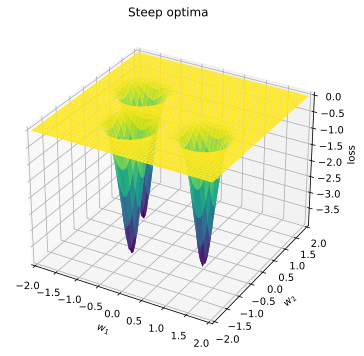

In [42]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * tf.math.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean= 1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean= 0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
plot_surface(comb_func, x_range=(-2,2), y_range=(-2,2), title="Steep optima", ax=ax)
plt.show();

Most of the loss surface has very little to no gradients. However, close to the optima, we have very steep gradients. To reach the minimum when starting in a region with lower gradients, we expect an adaptive learning rate to be crucial. To verify this hypothesis, we can run our three optimizers on the surface:

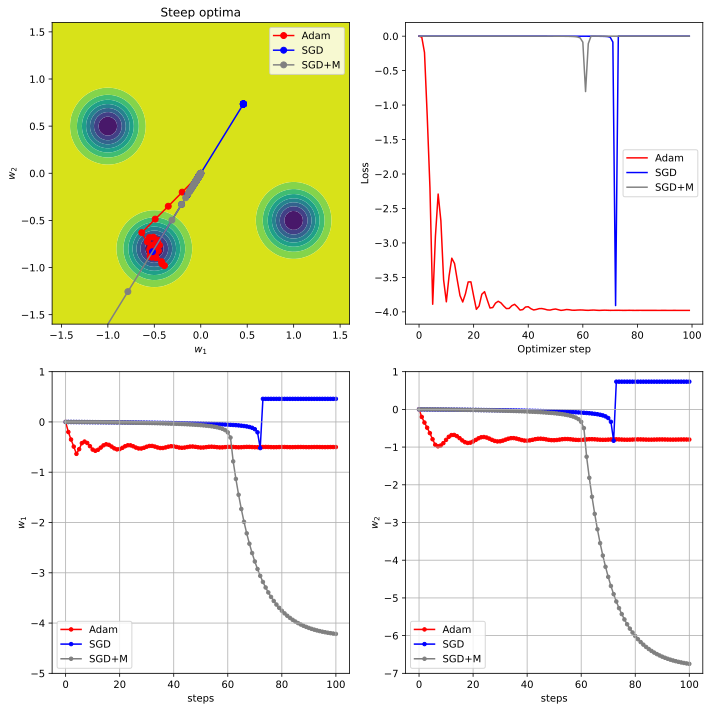

In [54]:
adam = lambda model: Adam(model, learning_rate=0.2)
sgd  = lambda model: SGD(model, learning_rate=0.5)
sgdm = lambda model: SGDMomentum(model, learning_rate=1, momentum=0.9)

init = [0., 0.]
path_adam, losses_adam = get_optimizer_path(adam, init, comb_func)
path_sgd,  losses_sgd  = get_optimizer_path(sgd,  init, comb_func)
path_sgdm, losses_sgdm = get_optimizer_path(sgdm, init, comb_func)

# Get ranges of coordinates of the optimization trajectories + padding
# x = w1 and y = w2, i.e. see ordering on output of get_weights function
all_points = np.concatenate([path_adam, path_sgd, path_sgdm], axis=0)
x_range = (-1.6, 1.6)
y_range = (-1.6, 1.6)

# Plot surface on box defined by coordinate ranges
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_contour(comb_func, "Steep optima", ax=ax[0, 0], x_range=x_range, y_range=y_range)

# Plot trajectory of optimizers
ax[0, 0].plot(path_adam[:, 0], path_adam[:, 1], color="red",  marker="o", zorder=1, label="Adam")
ax[0, 0].plot(path_sgd [:, 0], path_sgd [:, 1], color="blue", marker="o", zorder=1, label="SGD")
ax[0, 0].plot(path_sgdm[:, 0], path_sgdm[:, 1], color="gray", marker="o", zorder=1, label="SGD+M")
ax[0, 0].legend()

# Plot loss per optimizer step
ax[0, 1].plot(losses_adam, label='Adam',  color="red",  markersize=3.5)
ax[0, 1].plot(losses_sgd,  label='SGD',   color="blue", markersize=3.5)
ax[0, 1].plot(losses_sgdm, label='SGD+M', color="gray", markersize=3.5)
ax[0, 1].legend()
ax[0, 1].set_xlabel("Optimizer step")
ax[0, 1].set_ylabel("Loss")

# Plot x-axis of trajectory of optimizers
ax[1, 0].plot(path_adam[:, 0], color="red",  marker="o", zorder=1, label="Adam",  markersize=3.5)
ax[1, 0].plot(path_sgd [:, 0], color="blue", marker="o", zorder=1, label="SGD",   markersize=3.5)
ax[1, 0].plot(path_sgdm[:, 0], color="gray", marker="o", zorder=1, label="SGD+M", markersize=3.5)
ax[1, 0].legend()
ax[1, 0].grid()
ax[1, 0].set_xlabel("steps")
ax[1, 0].set_ylabel(r"$w_1$")
ax[1, 0].set_ylim(-5, 1)

# Plot y-axis of trajectory of optimizers
ax[1, 1].plot(path_adam[:, 1], color="red",  marker="o", zorder=1, label="Adam",  markersize=3.5)
ax[1, 1].plot(path_sgd [:, 1], color="blue", marker="o", zorder=1, label="SGD",   markersize=3.5)
ax[1, 1].plot(path_sgdm[:, 1], color="gray", marker="o", zorder=1, label="SGD+M", markersize=3.5)
ax[1, 1].legend()
ax[1, 1].grid()
ax[1, 1].set_xlabel("steps")
ax[1, 1].set_ylabel(r"$w_2$")
ax[1, 1].set_ylim(-7, 1)

plt.tight_layout()
plt.show();

SGD first takes very small steps until it touches the border of the optimum. First reaching a point around $(-0.5,-0.9)$, the gradient direction has changed and pushes the parameters to $(0.5, 0.9)$ from which SGD cannot recover anymore (only with many, many steps). A similar problem has SGD with momentum, only that it continues the direction of the touch of the optimum. The gradients from this time step are so much larger than any other point that the momentum ${\boldsymbol m}_t$ is overpowered by it despite having the factor $(1-\beta_1) = 0.1.$ Finally, Adam is able to converge in the optimum showing the importance of adaptive learning rates.

### What optimizer to take

After seeing the results on optimization, what is our conclusion? Should we always use Adam and never look at SGD anymore? The short answer: no. There are many papers saying that in certain situations, SGD (with momentum) generalizes better where Adam often tends to overfit [[1](https://proceedings.neurips.cc/paper/2017/file/81b3833e2504647f9d794f7d7b9bf341-Paper.pdf), [2](https://arxiv.org/abs/1609.04747)]. This is related to the idea of finding wider optima. For instance, see the illustration of different optima below (credit: [Keskar et al., 2017](https://arxiv.org/pdf/1609.04836.pdf)):

```{figure} ../../img/flat_vs_sharp_minima.svg
```

The black line represents the training loss surface, while the dotted red line is the test loss. Finding sharp, narrow minima can be helpful for finding the minimal training loss. However, this doesn't mean that it also minimizes the test loss as especially flat minima have shown to generalize better. You can imagine that the test dataset has a slightly shifted loss surface due to the different examples than in the training set. A small change can have a significant influence for sharp minima, while flat minima are generally more robust to this change. 

In the notebook [Inception, ResNet, and DenseNet](https://particle1331.github.io/steepest-ascent/notebooks/seb3/06-tensorflow-inception.html), we will see that some network types can still be better optimized with SGD and learning rate scheduling than Adam. Nevertheless, Adam is the most commonly used optimizer in Deep Learning as it usually performs better than other optimizers, especially for deep networks.

## Conclusion

In this notebook, we have looked at initialization and optimization techniques for neural networks. We have seen that a good initialization has to balance the preservation of the gradient variance as well as the activation variance. This can be achieved with the Xavier initialization for tanh-based networks, and the Kaiming initialization for ReLU-based networks. In optimization, concepts like momentum and adaptive learning rate can help with challenging loss surfaces but don’t guarantee an increase in performance for neural networks.
